##Deep Learning Assignemnt 1
####Aditya Karthully
####a1899982

###Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

####Load Data

In [20]:
X, y = load_svmlight_file('data.csv')
X = X.toarray()

In [23]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (768, 8)
y shape: (768,)


####Standardize Features

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

####Split Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}')

Training data shape: (614, 8), Training labels shape: (614,)
Test data shape: (154, 8), Test labels shape: (154,)


####Traditional Perceptron Implementation

In [28]:
class BasicPerceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=100):
        self.weights = np.zeros(input_size)
        self.bias = 0
        self.lr = learning_rate
        self.epochs = epochs

    def activation(self, x):
        return np.where(x >= 0, 1, -1)

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)

    def fit(self, X, y):
        for epoch in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activation(linear_output)
                # Perceptron update rule
                if y[idx] != y_predicted:
                    self.weights += self.lr * y[idx] * x_i
                    self.bias += self.lr * y[idx]
            if (epoch + 1) % 10 == 0:
                predictions = self.predict(X)
                accuracy = accuracy_score(y, predictions)
                print(f'Epoch {epoch+1}/{self.epochs}, Training Accuracy: {accuracy * 100:.2f}%')

In [29]:
#Train
input_size = X_train.shape[1]
basic_perceptron = BasicPerceptron(input_size, learning_rate=0.1, epochs=100)
basic_perceptron.fit(X_train, y_train)

Epoch 10/100, Training Accuracy: 74.76%
Epoch 20/100, Training Accuracy: 70.85%
Epoch 30/100, Training Accuracy: 69.22%
Epoch 40/100, Training Accuracy: 73.78%
Epoch 50/100, Training Accuracy: 72.64%
Epoch 60/100, Training Accuracy: 72.15%
Epoch 70/100, Training Accuracy: 74.10%
Epoch 80/100, Training Accuracy: 72.64%
Epoch 90/100, Training Accuracy: 71.50%
Epoch 100/100, Training Accuracy: 72.64%


In [30]:
# Predict
y_pred_basic = basic_perceptron.predict(X_test)

In [31]:
# Accuracy
accuracy_basic = accuracy_score(y_test, y_pred_basic)
print(f'\nTest Accuracy with Basic Perceptron: {accuracy_basic * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_basic, target_names=['-1 (Non-Diabetic)', '+1 (Diabetic)']))


Test Accuracy with Basic Perceptron: 80.52%

Classification Report:
                   precision    recall  f1-score   support

-1 (Non-Diabetic)       0.80      0.60      0.69        55
    +1 (Diabetic)       0.81      0.92      0.86        99

         accuracy                           0.81       154
        macro avg       0.81      0.76      0.77       154
     weighted avg       0.81      0.81      0.80       154



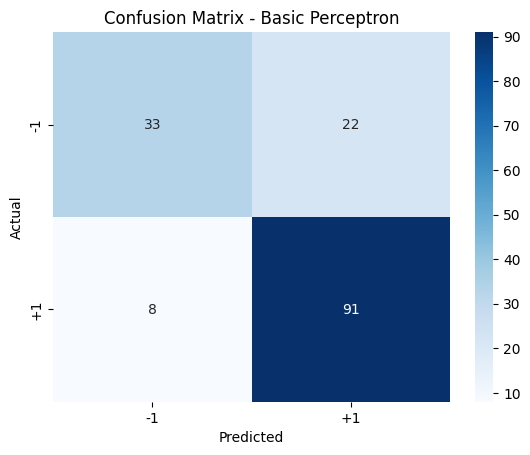

In [32]:
# Confusion matrix
cm_basic = confusion_matrix(y_test, y_pred_basic)
sns.heatmap(cm_basic, annot=True, fmt="d", cmap='Blues', xticklabels=['-1', '+1'], yticklabels=['-1', '+1'])
plt.title('Confusion Matrix - Basic Perceptron')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

####Enhanced Perceptron Implementation

In [34]:
class SigmoidPerceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, lambda_=0.01):
        self.weights = np.random.randn(input_size) * 0.01
        self.bias = 0
        self.lr = learning_rate
        self.epochs = epochs
        self.lambda_ = lambda_

    def activation(self, x):
        # Sigmoid activation function
        return 1 / (1 + np.exp(-x))

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)

    def compute_loss(self, y_true, y_pred):
        # L2 regularization
        m = len(y_true)
        loss = - (1/m) * np.sum(
            y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15)
        ) + (self.lambda_ / (2*m)) * np.sum(np.square(self.weights))
        return loss

    def fit(self, X, y):
        m = X.shape[0]
        for epoch in range(self.epochs):
            y_pred = self.predict(X)


            dw = (1/m) * np.dot(X.T, (y_pred - y)) + (self.lambda_/m) * self.weights
            db = (1/m) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if (epoch + 1) % 100 == 0:
                loss = self.compute_loss(y, y_pred)
                y_pred_class = np.where(y_pred >= 0.5, 1, 0)
                train_accuracy = accuracy_score(y, y_pred_class)
                print(f'Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%')


In [35]:
# Adjust labels -> (0 and 1 instead of -1 and +1)
y_sigmoid = np.where(y == -1, 0, 1)

In [36]:
# Split new data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_sigmoid, test_size=0.2, random_state=42)

In [37]:
#Train
input_size = X_train_s.shape[1]
sigmoid_perceptron = SigmoidPerceptron(input_size, learning_rate=0.1, epochs=1000, lambda_=0.1)
sigmoid_perceptron.fit(X_train_s, y_train_s)

Epoch 100/1000, Loss: 0.4804, Training Accuracy: 76.87%
Epoch 200/1000, Loss: 0.4703, Training Accuracy: 76.55%
Epoch 300/1000, Loss: 0.4685, Training Accuracy: 76.71%
Epoch 400/1000, Loss: 0.4681, Training Accuracy: 76.87%
Epoch 500/1000, Loss: 0.4681, Training Accuracy: 77.04%
Epoch 600/1000, Loss: 0.4680, Training Accuracy: 77.04%
Epoch 700/1000, Loss: 0.4680, Training Accuracy: 77.04%
Epoch 800/1000, Loss: 0.4680, Training Accuracy: 77.04%
Epoch 900/1000, Loss: 0.4680, Training Accuracy: 77.04%
Epoch 1000/1000, Loss: 0.4680, Training Accuracy: 77.04%


In [38]:
# Predict
y_pred_prob = sigmoid_perceptron.predict(X_test_s)
y_pred_sigmoid = np.where(y_pred_prob >= 0.5, 1, 0)

In [39]:
# Accuracy
accuracy_sigmoid = accuracy_score(y_test_s, y_pred_sigmoid)
print(f'\nTest Accuracy with Sigmoid Perceptron: {accuracy_sigmoid * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_sigmoid, target_names=['0 (Non-Diabetic)', '1 (Diabetic)']))


Test Accuracy with Sigmoid Perceptron: 75.32%

Classification Report:
                  precision    recall  f1-score   support

0 (Non-Diabetic)       0.65      0.67      0.66        55
    1 (Diabetic)       0.81      0.80      0.81        99

        accuracy                           0.75       154
       macro avg       0.73      0.74      0.73       154
    weighted avg       0.76      0.75      0.75       154



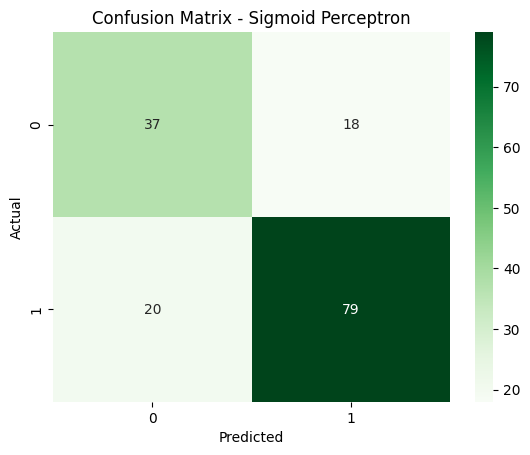

In [40]:
# Confusion matrix
cm_sigmoid = confusion_matrix(y_test_s, y_pred_sigmoid)
sns.heatmap(cm_sigmoid, annot=True, fmt="d", cmap='Greens', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix - Sigmoid Perceptron')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Test with different hyperparameters

In [41]:
input_size = X_train_s.shape[1]
sigmoid_perceptron = SigmoidPerceptron(input_size, learning_rate=0.01, epochs=1000, lambda_=0.0001)
sigmoid_perceptron.fit(X_train_s, y_train_s)

y_pred_prob = sigmoid_perceptron.predict(X_test_s)
y_pred_sigmoid = np.where(y_pred_prob >= 0.5, 1, 0)

accuracy_sigmoid = accuracy_score(y_test_s, y_pred_sigmoid)
print(f'\nTest Accuracy with Sigmoid Perceptron: {accuracy_sigmoid * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_sigmoid, target_names=['0 (Non-Diabetic)', '1 (Diabetic)']))


Epoch 100/1000, Loss: 0.6016, Training Accuracy: 76.06%
Epoch 200/1000, Loss: 0.5572, Training Accuracy: 76.55%
Epoch 300/1000, Loss: 0.5316, Training Accuracy: 76.22%
Epoch 400/1000, Loss: 0.5154, Training Accuracy: 76.38%
Epoch 500/1000, Loss: 0.5044, Training Accuracy: 76.22%
Epoch 600/1000, Loss: 0.4965, Training Accuracy: 76.38%
Epoch 700/1000, Loss: 0.4907, Training Accuracy: 76.38%
Epoch 800/1000, Loss: 0.4863, Training Accuracy: 76.55%
Epoch 900/1000, Loss: 0.4829, Training Accuracy: 76.87%
Epoch 1000/1000, Loss: 0.4802, Training Accuracy: 76.87%

Test Accuracy with Sigmoid Perceptron: 73.38%

Classification Report:
                  precision    recall  f1-score   support

0 (Non-Diabetic)       0.62      0.64      0.63        55
    1 (Diabetic)       0.80      0.79      0.79        99

        accuracy                           0.73       154
       macro avg       0.71      0.71      0.71       154
    weighted avg       0.73      0.73      0.73       154



In [42]:
input_size = X_train_s.shape[1]
sigmoid_perceptron = SigmoidPerceptron(input_size, learning_rate=0.001, epochs=1000, lambda_=0.001)
sigmoid_perceptron.fit(X_train_s, y_train_s)

y_pred_prob = sigmoid_perceptron.predict(X_test_s)
y_pred_sigmoid = np.where(y_pred_prob >= 0.5, 1, 0)

accuracy_sigmoid = accuracy_score(y_test_s, y_pred_sigmoid)
print(f'\nTest Accuracy with Sigmoid Perceptron: {accuracy_sigmoid * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_sigmoid, target_names=['0 (Non-Diabetic)', '1 (Diabetic)']))


Epoch 100/1000, Loss: 0.6857, Training Accuracy: 67.75%
Epoch 200/1000, Loss: 0.6738, Training Accuracy: 72.96%
Epoch 300/1000, Loss: 0.6629, Training Accuracy: 74.43%
Epoch 400/1000, Loss: 0.6527, Training Accuracy: 75.08%
Epoch 500/1000, Loss: 0.6433, Training Accuracy: 75.41%
Epoch 600/1000, Loss: 0.6346, Training Accuracy: 75.24%
Epoch 700/1000, Loss: 0.6266, Training Accuracy: 75.57%
Epoch 800/1000, Loss: 0.6191, Training Accuracy: 75.57%
Epoch 900/1000, Loss: 0.6121, Training Accuracy: 75.90%
Epoch 1000/1000, Loss: 0.6056, Training Accuracy: 75.90%

Test Accuracy with Sigmoid Perceptron: 70.78%

Classification Report:
                  precision    recall  f1-score   support

0 (Non-Diabetic)       0.59      0.62      0.60        55
    1 (Diabetic)       0.78      0.76      0.77        99

        accuracy                           0.71       154
       macro avg       0.68      0.69      0.69       154
    weighted avg       0.71      0.71      0.71       154



In [43]:
input_size = X_train_s.shape[1]
sigmoid_perceptron = SigmoidPerceptron(input_size, learning_rate=0.01, epochs=10000, lambda_=0.0001)
sigmoid_perceptron.fit(X_train_s, y_train_s)

y_pred_prob = sigmoid_perceptron.predict(X_test_s)
y_pred_sigmoid = np.where(y_pred_prob >= 0.5, 1, 0)

accuracy_sigmoid = accuracy_score(y_test_s, y_pred_sigmoid)
print(f'\nTest Accuracy with Sigmoid Perceptron: {accuracy_sigmoid * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_sigmoid, target_names=['0 (Non-Diabetic)', '1 (Diabetic)']))


Epoch 100/10000, Loss: 0.6021, Training Accuracy: 76.22%
Epoch 200/10000, Loss: 0.5572, Training Accuracy: 76.55%
Epoch 300/10000, Loss: 0.5315, Training Accuracy: 76.22%
Epoch 400/10000, Loss: 0.5153, Training Accuracy: 76.22%
Epoch 500/10000, Loss: 0.5043, Training Accuracy: 76.38%
Epoch 600/10000, Loss: 0.4964, Training Accuracy: 76.38%
Epoch 700/10000, Loss: 0.4907, Training Accuracy: 76.55%
Epoch 800/10000, Loss: 0.4863, Training Accuracy: 76.38%
Epoch 900/10000, Loss: 0.4829, Training Accuracy: 76.71%
Epoch 1000/10000, Loss: 0.4802, Training Accuracy: 77.04%
Epoch 1100/10000, Loss: 0.4781, Training Accuracy: 76.87%
Epoch 1200/10000, Loss: 0.4764, Training Accuracy: 77.04%
Epoch 1300/10000, Loss: 0.4750, Training Accuracy: 76.55%
Epoch 1400/10000, Loss: 0.4739, Training Accuracy: 76.55%
Epoch 1500/10000, Loss: 0.4729, Training Accuracy: 76.55%
Epoch 1600/10000, Loss: 0.4722, Training Accuracy: 76.55%
Epoch 1700/10000, Loss: 0.4715, Training Accuracy: 76.55%
Epoch 1800/10000, Loss:

In [44]:
input_size = X_train_s.shape[1]
sigmoid_perceptron = SigmoidPerceptron(input_size, learning_rate=0.01, epochs=100000, lambda_=0.001)
sigmoid_perceptron.fit(X_train_s, y_train_s)

y_pred_prob = sigmoid_perceptron.predict(X_test_s)
y_pred_sigmoid = np.where(y_pred_prob >= 0.5, 1, 0)

accuracy_sigmoid = accuracy_score(y_test_s, y_pred_sigmoid)
print(f'\nTest Accuracy with Sigmoid Perceptron: {accuracy_sigmoid * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test_s, y_pred_sigmoid, target_names=['0 (Non-Diabetic)', '1 (Diabetic)']))


Epoch 100/100000, Loss: 0.6033, Training Accuracy: 75.57%
Epoch 200/100000, Loss: 0.5579, Training Accuracy: 76.22%
Epoch 300/100000, Loss: 0.5320, Training Accuracy: 76.22%
Epoch 400/100000, Loss: 0.5156, Training Accuracy: 76.55%
Epoch 500/100000, Loss: 0.5045, Training Accuracy: 76.22%
Epoch 600/100000, Loss: 0.4966, Training Accuracy: 76.38%
Epoch 700/100000, Loss: 0.4907, Training Accuracy: 76.38%
Epoch 800/100000, Loss: 0.4863, Training Accuracy: 76.55%
Epoch 900/100000, Loss: 0.4829, Training Accuracy: 76.87%
Epoch 1000/100000, Loss: 0.4802, Training Accuracy: 76.71%
Epoch 1100/100000, Loss: 0.4781, Training Accuracy: 76.71%
Epoch 1200/100000, Loss: 0.4764, Training Accuracy: 76.71%
Epoch 1300/100000, Loss: 0.4750, Training Accuracy: 77.04%
Epoch 1400/100000, Loss: 0.4738, Training Accuracy: 76.55%
Epoch 1500/100000, Loss: 0.4729, Training Accuracy: 76.55%
Epoch 1600/100000, Loss: 0.4721, Training Accuracy: 76.38%
Epoch 1700/100000, Loss: 0.4715, Training Accuracy: 76.38%
Epoch 